In [79]:
import sys
sys.path.append('../')
sys.path.insert(0,'/home/abel/Documents/Projects/BioMath/EPFL/ATDS')

import numpy as np
from scipy import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from xppcall import xpprun
import networkx as nx

import conley_functions as cf

from ripser import ripser
from persim import plot_diagrams
import subprocess

N = 16
R = 6
ell = 2
W0 = 2.5
time=10 #simulation time

def make_connection_matrix(N, W0, R, ell):
    #construct a connection matrix as in Couey 2013
    theta = zeros([N])
    theta[0:N:2] = 0
    theta[1:N:2] = 1
    theta = 0.5*pi*theta
    theta = ravel(theta)
    xes = zeros(N)
    for x in range(N):
      xes[x] = x
    
    Wgen = zeros([N,N], dtype=bool)
    for x in range(N):
      xdiff = abs(xes-x-ell*cos(theta))
      xdiff = minimum(xdiff, N-xdiff)
      Wgen[xdiff<R,x] = 1
    W = zeros([N,N])
    W[Wgen>0.7] = -W0
    return W, theta

####Set up network weights
W,theta=make_connection_matrix(N, W0, R, ell)

<IPython.core.display.Javascript object>


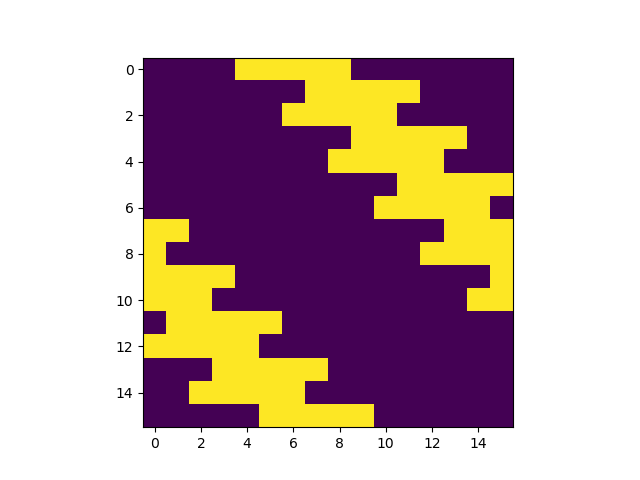

In [80]:
%matplotlib notebook

plt.imshow(W)
plt.show()

In [77]:
#make file to simulate Wilson-Cowan network with XPP
eqstring = ''
wi = 0
for i in range(1,W.shape[0]+1):
    eqstring+='x'+str(i)+"'=(-x"+str(i)+"+f(I+"
    for j in range(1,W.shape[1]+1):
        if i!=j:
            eqstring+='w'+str(wi)+"*x"+str(j)+'+'
        wi+=1
    eqstring=eqstring[:-1]+'))/tau\n'
weighstring = 'p '
wi=0
for i in range(0,W.shape[0]):
    for j in range(0,W.shape[1]):
        weighstring+='w'+str(wi)+'='+str(round(W[i,j], 2))+','
        wi+=1
        
initstring = 'init '
inits = np.random.rand(N)
for i in range(W.shape[0]):
        initstring+='x'+str(int(i+1))+'='+str(inits[i])+','

wcstring = "# the HD equations\n"
wcstring += "f(x)=if(x<0)then(0)else(x)\n"
wcstring += eqstring[:-1] + "\n"
wcstring += weighstring[:-1] + "\n"
wcstring += "par I=3,tau=1\n"
wcstring += initstring[:-1] + "\n"
wcstring += '@ xp=x1,xlo=-.125,xhi=1\n'
wcstring += "done"
with open('hd_p.ode', 'w') as f:
    f.writelines(wcstring)

In [81]:
wcstring = "# the HD equations\n"
wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
wcstring+="f(x)=if(x<0)then(0)else(x)\n"
wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
wcstring+="h(x)=min(x,N-x)\n"
wcstring+="theta(t)=pi*cos(t/100)\n"
wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N

initstring = 'init '
inits = np.round(np.random.rand(N), 1)
# inits = np.roll(npa[-1,1:],10)
inits = np.roll(array([1.1423563e-31, 8.3024368e-02, 8.2721494e-02, 0.0000000e+00,
       7.4570489e-01, 4.1417581e-01, 9.1166961e-01, 9.1153479e-01,
       4.1455349e-01, 7.4600780e-01, 1.2236788e-31, 8.3024368e-02,
       8.2721494e-02, 0.0000000e+00, 7.4570489e-01, 4.1417581e-01,
       9.1166961e-01, 9.1153479e-01, 4.1455349e-01, 7.4600780e-01,
       2.4396040e-31, 8.3024368e-02, 8.2721494e-02, 0.0000000e+00,
       7.4570489e-01, 4.1417581e-01, 9.1166961e-01, 9.1153479e-01,
       4.1455349e-01, 7.4600780e-01, 3.0570821e-31, 8.3024368e-02,
       8.2721494e-02, 0.0000000e+00, 7.4570489e-01, 4.1417581e-01,
       9.1166961e-01, 9.1153479e-01, 4.1455349e-01, 7.4600780e-01,
       1.7527835e-31, 8.3024368e-02, 8.2721494e-02, 0.0000000e+00,
       7.4570489e-01, 4.1417581e-01, 9.1166961e-01, 9.1153479e-01,
       4.1455349e-01, 7.4600780e-01]), 2)
for i in range(W.shape[0]):
        initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
wcstring += initstring[:-1] + "\n"
wcstring += "done"

with open('hdring_p.ode', 'w') as f:
    f.writelines(wcstring)

In [82]:
time=200
# randint = 2*(np.random.random(N)-0.5)
# inits_dict={}
# for i,init in enumerate(randint[:5]):
#     inits_dict['u'+str(i+1)] = round(init,2)
# print(inits_dict)
# npa, vn = xpprun('hd_p.ode', parameters={'total':time}, clean_after=True)
# npa, vn = xpprun('hdring_p.ode',inits=inits_dict, parameters={'total':time}, clean_after=True)
npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)
# npa, vn = xpprun(path_to_ode+'hdring_p.ode', parameters={'total':time}, clean_after=True)

<IPython.core.display.Javascript object>


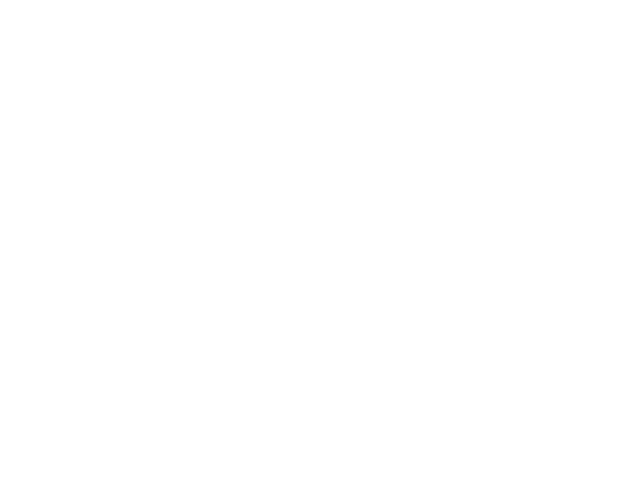

In [83]:
%matplotlib notebook

plt.plot(npa[-1,1:], 'x')
plt.show()

<IPython.core.display.Javascript object>


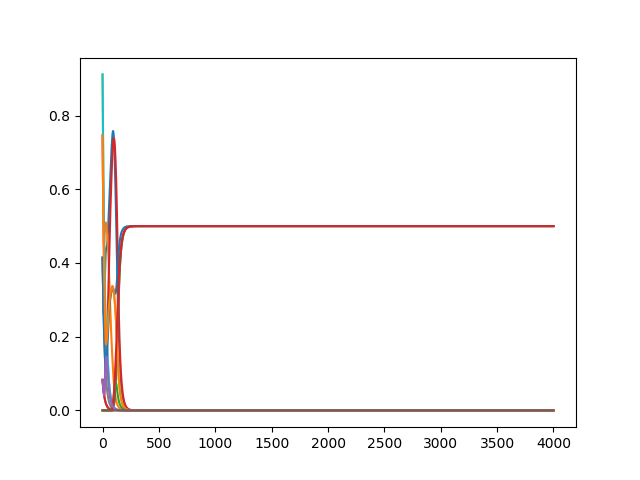

In [84]:
%matplotlib notebook

plt.plot(npa[:,1:])
plt.show()

In [86]:
%matplotlib notebook
time = 50
nshifts = 20
datas = np.zeros((nshifts, time*20+1, npa[:,1:].shape[1]))
for jroll in range(1,nshifts+1):
    wcstring = "# the HD equations\n"
    wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
    wcstring+="f(x)=if(x<0)then(0)else(x)\n"
    wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
    wcstring+="h(x)=min(x,N-x)\n"
    wcstring+="theta(t)=pi*cos(t/100)\n"
    wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N

    initstring = 'init '
    inits = np.random.random(N)
    for i in range(W.shape[0]):
            initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
    wcstring += initstring[:-1] + "\n"
    wcstring += "done"

    with open('hdring_p.ode', 'w') as f:
        f.writelines(wcstring)
    npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)
    datas[jroll-1, :, :] = npa[:,1:].copy()

<IPython.core.display.Javascript object>


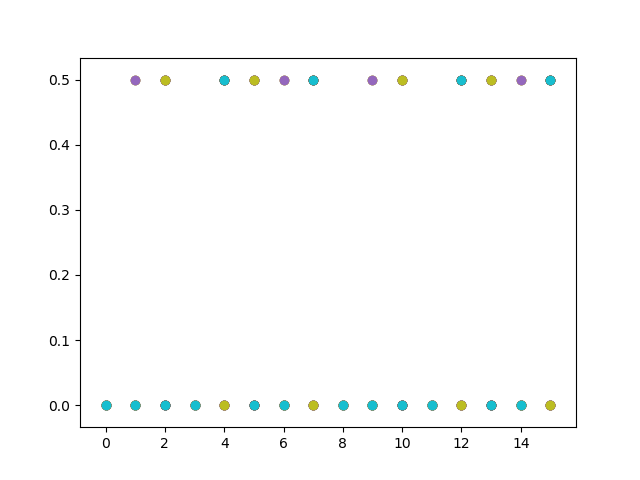

In [89]:
%matplotlib notebook

for shi in range(nshifts):
    plt.scatter([i for i in range(N)], datas[shi,-1,:])

<IPython.core.display.Javascript object>


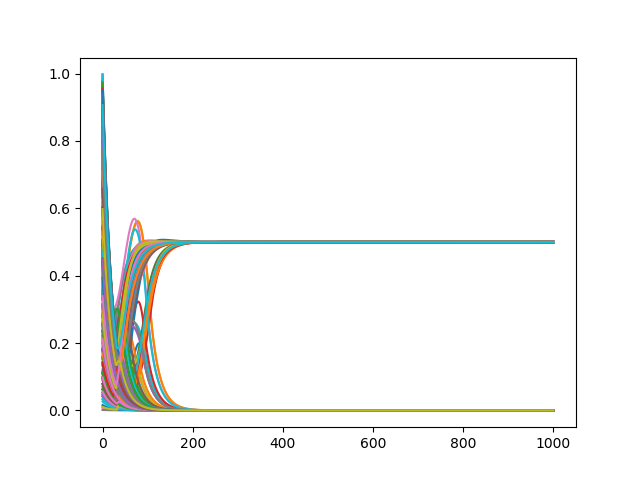

In [88]:
%matplotlib notebook

for shi in range(nshifts):
    plt.plot(datas[shi,:,:])

In [90]:
%matplotlib notebook
time = 50
originits = npa[-1,1:]
nshifts = 10
datas = np.zeros((nshifts, time*20+1, npa[:,1:].shape[1]))
for jroll in range(1,nshifts+1):
    wcstring = "# the HD equations\n"
    wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
    wcstring+="f(x)=if(x<0)then(0)else(x)\n"
    wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
    wcstring+="h(x)=min(x,N-x)\n"
    wcstring+="theta(t)=pi*cos(t/100)\n"
    wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N

    initstring = 'init '
#     inits = np.roll(npa[-1,1:],jroll)
    inits = np.roll(originits, jroll)
    for i in range(W.shape[0]):
            initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
    wcstring += initstring[:-1] + "\n"
    wcstring += "done"

    with open('hdring_p.ode', 'w') as f:
        f.writelines(wcstring)
    npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)
    datas[jroll-1, :, :] = npa[:,1:].copy()
#     plt.plot(npa[-1,1:].copy(), 'x')
# plt.show()

<IPython.core.display.Javascript object>


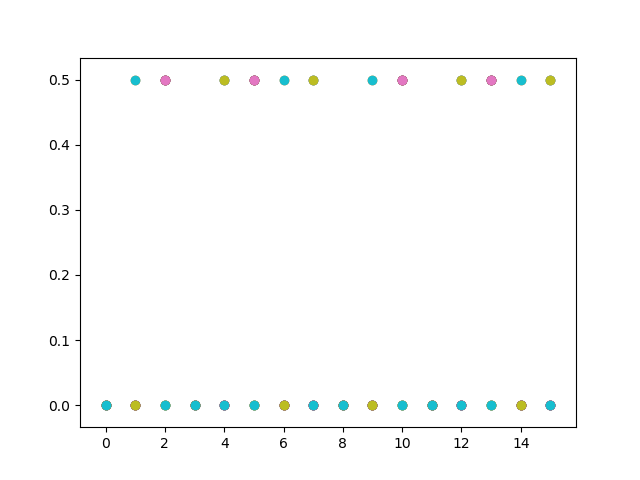

In [91]:
%matplotlib notebook

for shi in range(nshifts):
    plt.scatter([i for i in range(N)], datas[shi,-1,:])

In [92]:
# %matplotlib notebook

# for shi in range(15,20):
#     plt.scatter([i for i in range(N)], datas[shi,-1,:])

In [93]:
# %matplotlib notebook

# for shi in range(nshifts):
#     plt.plot(datas[shi,:,0])

<IPython.core.display.Javascript object>


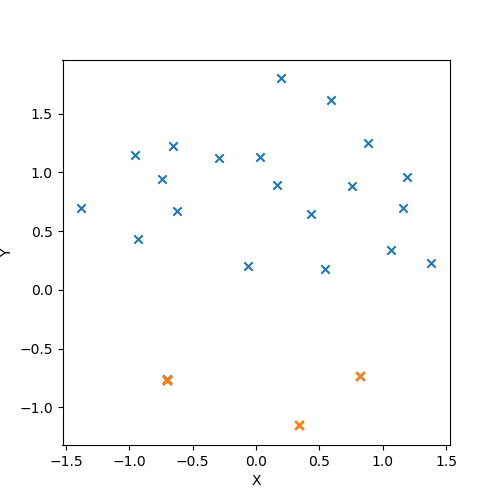

In [62]:
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

p=2
embedding = MDS(n_components=p)
both = np.array([datas[:,0,:], datas[:,-1,:]])
both = np.reshape(both, (both.shape[0]*both.shape[1], both.shape[2]))
X_transformed = embedding.fit_transform(both)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.scatter(X_transformed[:25,0], X_transformed[:25,1], marker="x", label='Begin')
cax = ax.scatter(X_transformed[25:,0], X_transformed[25:,1], marker="x", label='End')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

/home/abel/anaconda3/envs/atds/lib/python3.7/site-packages/ripser/ripser.py:220: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "


<IPython.core.display.Javascript object>


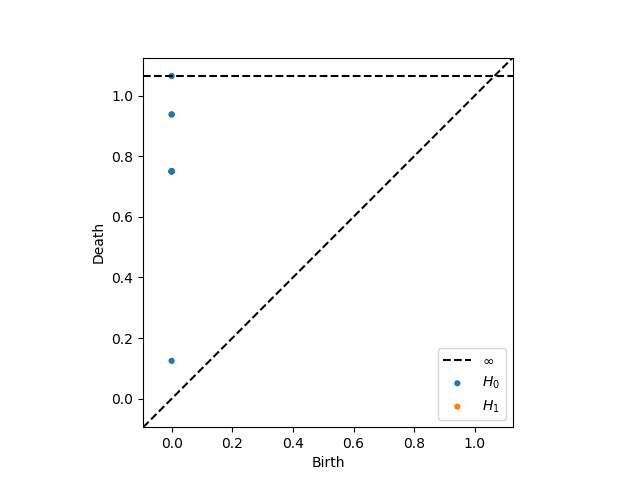

In [94]:
%matplotlib notebook

from ripser import ripser
from persim import plot_diagrams

dgms = ripser(datas[:,-1,:], metric='hamming')['dgms']
plot_diagrams(dgms, show=True)

In [29]:
# from scipy.spatial.distance import pdist
# from scipy.spatial.distance import squareform
# dists = pdist(datas[:-5,0,:], metric='hamming')
# squareddists = squareform(dists)

In [95]:
# %matplotlib notebook
# plt.imshow(squareddists)

In [96]:
time = 50
%matplotlib notebook
nshifts = 13
moredatas = np.zeros((2*nshifts+1, time*20+1, npa[:,1:].shape[1]))
starting = datas[0,-1,:]
for jroll in range(-nshifts,nshifts+1,1):
    wcstring = "# the HD equations\n"
    wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
    wcstring+="f(x)=if(x<0)then(0)else(x)\n"
    wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
    wcstring+="h(x)=min(x,N-x)\n"
    wcstring+="theta(t)=pi*cos(t/100)\n"
    wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N
    initstring = 'init '
    inits = np.roll(starting, jroll)
    for i in range(W.shape[0]):
            initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
    wcstring += initstring[:-1] + "\n"
    wcstring += "done"
    with open('hdring_p.ode', 'w') as f:
        f.writelines(wcstring)
    npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)
    moredatas[jroll+nshifts, :, :] = npa[:,1:].copy()

In [97]:
# %matplotlib notebook

# for i in range(N):
#     plt.plot(moredatas[1,:,i])

In [98]:
time = 50
%matplotlib notebook
nshifts = 13
moredatas2 = np.zeros((2*nshifts+1, time*20+1, npa[:,1:].shape[1]))
starting = moredatas[0,-1,:]
for jroll in range(-nshifts,nshifts+1,1):
    wcstring = "# the HD equations\n"
    wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
    wcstring+="f(x)=if(x<0)then(0)else(x)\n"
    wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
    wcstring+="h(x)=min(x,N-x)\n"
    wcstring+="theta(t)=pi*cos(t/100)\n"
    wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N
    initstring = 'init '
    inits = np.roll(starting, jroll)
    for i in range(W.shape[0]):
            initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
    wcstring += initstring[:-1] + "\n"
    wcstring += "done"
    with open('hdring_p.ode', 'w') as f:
        f.writelines(wcstring)
    npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)
    moredatas2[jroll+nshifts, :, :] = npa[:,1:].copy()

<IPython.core.display.Javascript object>


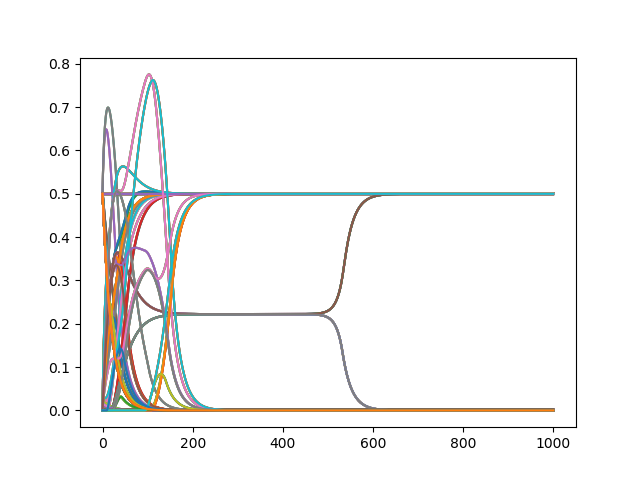

In [113]:
%matplotlib notebook
for i in range(moredatas2.shape[0]):
    plt.plot(moredatas2[i,:,:])

<IPython.core.display.Javascript object>


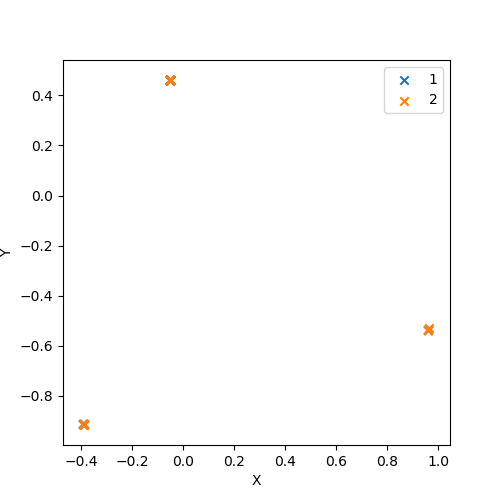

In [100]:
%matplotlib notebook
p=2
embedding = MDS(n_components=p)
both = np.array([moredatas[:,-1,:], moredatas2[:,-1,:]])
# both = np.array([moredatas2[:,-1,:]])
both = np.reshape(both, (both.shape[0]*both.shape[1], both.shape[2]))
X_transformed = embedding.fit_transform(both)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.scatter(X_transformed[:nshifts*2+1,0], X_transformed[:nshifts*2+1,1], marker="x", label='1')
cax = ax.scatter(X_transformed[nshifts*2+1:,0], X_transformed[nshifts*2+1:,1], marker="x", label='2')
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


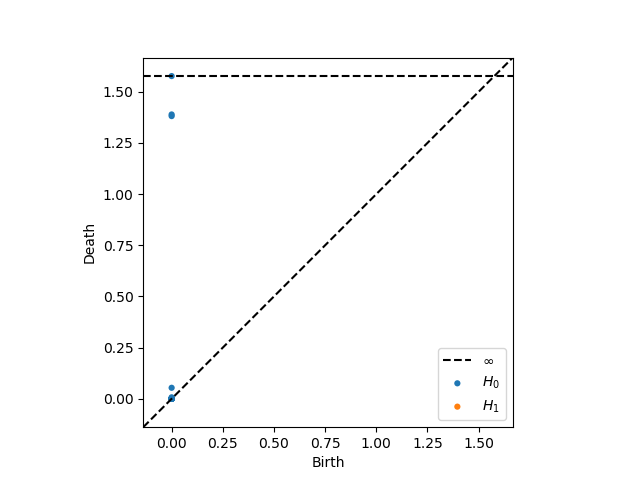

In [41]:
%matplotlib notebook
dgms = ripser(both)['dgms']
plot_diagrams(dgms, show=True)

<IPython.core.display.Javascript object>


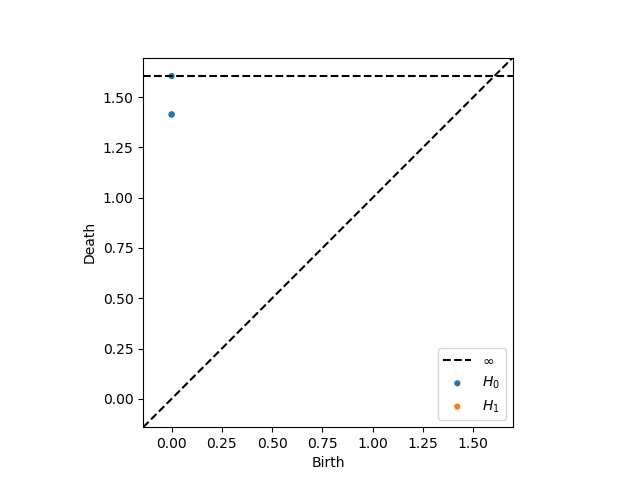

In [101]:
%matplotlib notebook
dgms = ripser(moredatas2[:,-1,:])['dgms']
plot_diagrams(dgms, show=True)

In [25]:
# dim = 50
# grid = cf.make_grid(dim, -1, 1, 1.)
# for gc in grid:
#     inits = {}
#     i = 0
#     for k in range(dim):   
#         key = 'u' + str(k)
#         value = grid[i][k]
#         inits[key] = value
#     npa, vn = xpprun(path_to_ode+'hdring.ode', inits=inits, parameters={'total':time}, clean_after=True)
#     data.append(npa[:,1:])

In [102]:
# #Simulate network with M random initial values 
# %matplotlib notebook
# M = 5
# dim = N
# time = 100
# data = np.array([[0]*N])
# datas = np.zeros((M, time*20+1, N))
# data_length_list = []
# for m in range(M):
#     wcstring = "# the HD equations\n"
#     wcstring+="param l=%s,c=%s,R=%s,I=3,a=1,N=%s,alpha=0\n"%(ell, -W0, R, N)
#     wcstring+="f(x)=if(x<0)then(0)else(x)\n"
#     wcstring+="g(x)=l*cos(0.5*pi*(mod(x,2)))\n"
#     wcstring+="h(x)=min(x,N-x)\n"
#     wcstring+="theta(t)=pi*cos(t/100)\n"
#     wcstring+="u[1..%s]'=a*(-u[j]+f(sum(1,N)of(c*heav(R-1-h(abs([j]-i'-g([j]))))*shift(u1,i'))+I+alpha*cos(theta(t)-0.5*pi*(mod([j],2)))))\n"%N

#     initstring = 'init '
#     inits = (np.round(np.random.rand(N), 1)-0.5)
#     for i in range(W.shape[0]):
#             initstring+='u['+str(int(i+1))+']='+str(inits[i])+' '
#     wcstring += initstring[:-1] + "\n"
#     wcstring += "done"

#     with open('hdring_p.ode', 'w') as f:
#         f.writelines(wcstring)
    
#     npa, vn = xpprun('hdring_p.ode', parameters={'total':time}, clean_after=True)

#     datas[m, :, :] = npa[:,1:].copy()
# #     plt.plot(npa[-1,1:].copy(), 'x')
# plt.show()

In [105]:
shift = 1000
alldata = np.array([moredatas[:, shift:, :3], moredatas2[:, shift:, :3]])
alldata = np.reshape(alldata, (2*alldata.shape[1]*alldata.shape[2], alldata.shape[3]))

data_length_list = [moredatas.shape[1]]*(2*nshifts+1)*2
alldata.shape

(54, 3)

In [106]:
alldata.shape

(54, 3)

In [107]:
#Make combinatorial dynamical system from the data
delta=0.01
cds = cf.Combinatorial_Dynamical_System(delta)
cds.initialise_with_data(alldata, data_length_list)

In [108]:
#Get the recurrent components (Morse sets)
RCs = cds.get_recurrent_components(includeselfedges=True)
len(RCs)

3

In [109]:
Rcubes = {}
for i in range(len(RCs)):
    Rcubes[i] = cds.convert_indices_to_cubes(RCs[i])

In [111]:
RPcubes = {}

for i in range(0,len(RCs)):#range(0,1)
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(cds.convert_indices_to_cubes(RCs[i]))
    
    # Betti numbers of recurrent components
#     print(cf.get_bettiNumbers_of_cubicalset(Rcubes[i], cds.delta))
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    N = RPcubes[i][0]
    N_ind = cds.convert_cubes_to_indices(N)
    S_ind = cds.invariantPart(N_ind)
    S_cubes = cds.convert_indices_to_cubes(S_ind)
    print("Finding isolated nbhd")
    M = cds.cubical_wrap(S_cubes).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
#     for mstep in range(5):
#         M = cds.cubical_wrap(M).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
    
    #calculate index pair
    try:
        print("Calculating index pair")
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        P1cubes = cds.convert_indices_to_cubes(P1)
        P0cubes = cds.convert_indices_to_cubes(P0)
        RPcubes[i].append(P1cubes)
        RPcubes[i].append(P0cubes)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        p1cubes = cds.convert_to_invertal_representation(P1cubes)
        filetxt= cf.convert_to_chomp_format(p1cubes, delta)
        with open('hd50_rc%s_p1.cub'%(i+1), 'w') as f:
            f.writelines(filetxt)

        if P0 != set():
            p0cubes = cds.convert_to_invertal_representation(P0cubes)
            filetxt= cf.convert_to_chomp_format(p0cubes, delta)
            with open('hd50_rc%s_p0.cub'%(i+1), 'w') as f:
                f.writelines(filetxt)
        else:
            0
#             print("P0 is empty")
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)

        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        print("Calculating homology")
        proc = subprocess.Popen(['homcubes','rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
        linenum = 0
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            if line.rstrip().decode('UTF-8')[0:2] == 'H_':
                print("           "+line.rstrip().decode('UTF-8'))
            linenum+=1
            
    except Exception as e:
        if e=='too many values to unpack (expected 4)':
            print('Faile')
        else:
            print(e)

Component 1
Finding isolated nbhd
Calculating index pair
Calculating homology
           H_0 = Z^3
Component 2
Finding isolated nbhd
Calculating index pair
Calculating homology
           H_0 = Z
Component 3
Finding isolated nbhd
Calculating index pair
Calculating homology
           H_0 = Z


In [60]:
len(RCs[i])

105